In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings
from typing import Tuple
from pathlib import Path
from copy import deepcopy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import plotly.express as px

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

sys.path.append("/app")
from visualizations.scripts.drawer import metric_viewer, russia_plots, russia_plots_n

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

### Read necessary geometry

In [3]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# basin_districts = basin_districts.drop([26, 27])
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

In [4]:
basin_districts

,name1,layer,path,geometry
0,лнр,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((36.223 46.563, 36.223 46.563, ..."
1,днр,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((32.557 46.067, 32.558 46.067, ..."
2,херсон,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((37.872 49.238, 37.873 49.237, ..."
3,сон,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((38.332 50.074, 38.332 50.071, ..."
4,Двинско-Печорский,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((38.855 59.409, 38.856 59.409, ..."
5,Балтийский,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((30.909 55.009, 30.9 55.03, 30...."
6,Ангаро-Байкальский,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((111.15 50.811, 111.15 50.779, ..."
7,Баренцево-Беломорский,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((36.501 63.256, 36.501 63.245, ..."
8,Амурский,basin_districts,F:/Data/phd_data/geometry/basin_districts.gpkg...,"MULTIPOLYGON (((142.76 46.638, 142.76 46.622, ..."
9,Ленский. обрез,basin_districts,"MultiPolygon?crs=EPSG:4326&field=fid:long(0,0)...","MULTIPOLYGON (((112.76 52.323, 112.76 52.323, ..."


In [5]:
def read_table_gauge_str(
    table_path: str, index_filter: pd.Index = pd.Index([])
) -> tuple[pd.DataFrame, float]:
    table = pd.read_csv(table_path)
    if "Unnamed: 0" in table.columns:
        table = table.rename(columns={"Unnamed: 0": "gauge_id"})
    table["gauge_id"] = table["gauge_id"].astype(str)
    table = table.set_index("gauge_id")

    if index_filter.empty:
        pass
    else:
        table = table.loc[table.index.isin(index_filter)]
    median_nse = table["NSE"].median()
    return table, median_nse

### Use only gauges from LSTM model

In [6]:
hbv_table = pd.read_csv(
    "./tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

gr4j_table = pd.read_csv(
    "./tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "./tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_regional = pd.read_csv(
    "./tables/cudalstm_q_mm_day_mswep_era5_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_single = pd.read_csv(
    "./tables/Single_LSTM_table.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_no_static = pd.read_csv(
    "./tables/LSTM_no_static_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_regional.index)
    .intersection(ws_file.index)
    .intersection(lstm_single.index)
    .intersection(lstm_no_static.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file['size'] = np.NaN
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### HBV and GR4J

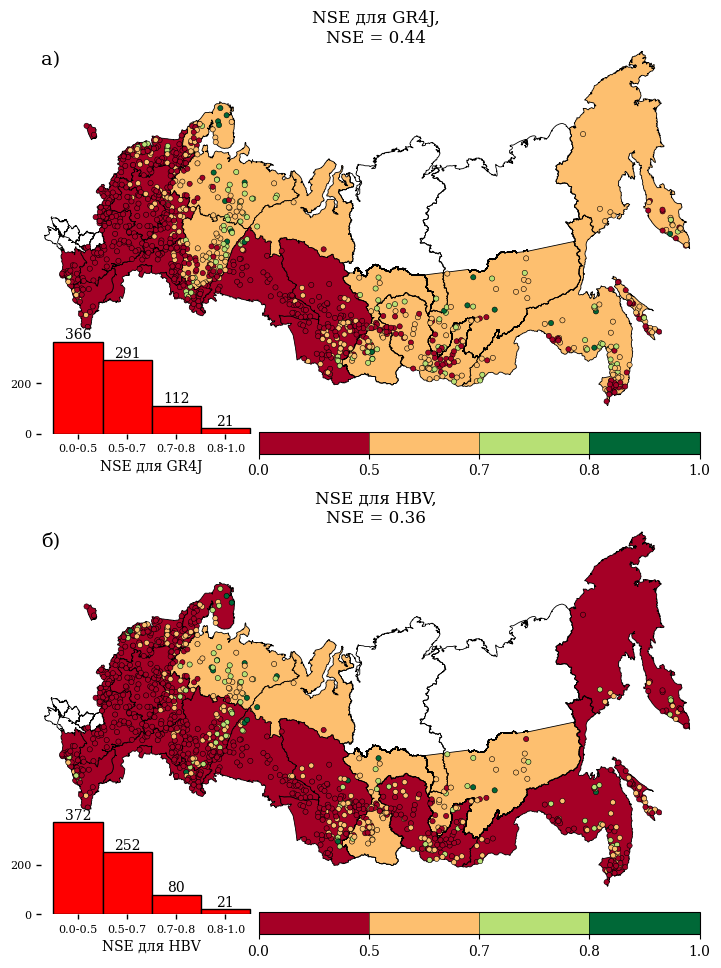

In [14]:
hbv_table, nse_hbv = read_table_gauge_str(
    table_path="./tables/HBV_res_mle_NSE.csv", index_filter=common_index
)
gr4j_table, nse_gr4j = read_table_gauge_str(
    table_path="./tables/GR4J_res_mle_NSE.csv", index_filter=common_index
)

hbv_gr4j_nse = gauges_file.loc[:, ["geometry"]]

hbv_gr4j_nse.loc[:, ["NSE GR4J", "NSE HBV"]] = pd.concat(
    [gr4j_table.loc[common_index, "NSE"], hbv_table.loc[common_index, "NSE"]],
    axis=1,
).values
hbv_gr4j_nse = hbv_gr4j_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = hbv_gr4j_nse.loc[
        [geom.intersects(gage_point) for gage_point in hbv_gr4j_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE GR4J", "NSE HBV"]] = ugms_part[["NSE GR4J", "NSE HBV"]].median()

basin_districts.loc[[26, 27], ["NSE GR4J", "NSE HBV"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=hbv_gr4j_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=2,
    ncols=1,
    label_list=["а)", "б)"],
    columns_from_gdf=["NSE GR4J", "NSE HBV"],
    hist_name=["NSE для GR4J", "NSE для HBV"],
    with_histogram=True,
    title_text=[
        f"NSE для GR4J,\nNSE = {nse_gr4j:.2f}",
        f"NSE для HBV,\nNSE = {nse_hbv:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


In [35]:
gr4j_hbv = pd.concat([hbv_table.median().to_frame().T, gr4j_table.median().to_frame().T])

gr4j_hbv.index = pd.Index(["HBV", "GR4J"])

gr4j_hbv.to_excel("/app/geo_data/results/gr4j_hbv_statistics.xlsx",
                  float_format="%.2f")

### Random forest

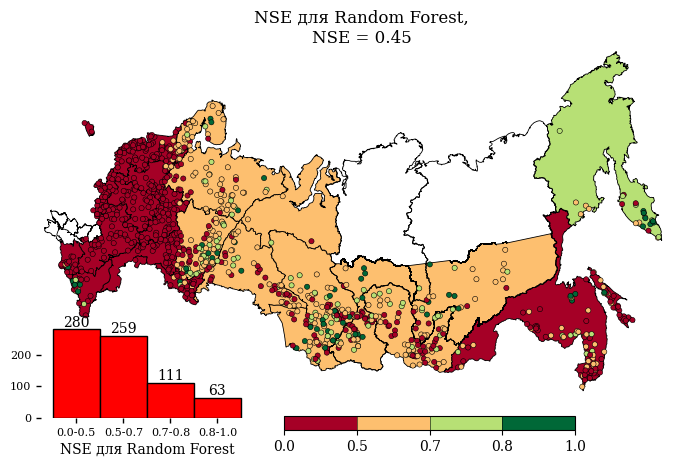

In [15]:
rfr_table, rfr_nse = read_table_gauge_str(
    table_path="./tables/res_rfr_cv.csv", index_filter=common_index
)

rfr_geom_nse = gauges_file.loc[:, ["geometry"]]

rfr_geom_nse.loc[:, ["NSE Random Forest"]] = pd.concat(
    [rfr_table.loc[common_index, "NSE"]],
    axis=1,
).values
rfr_geom_nse = rfr_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = rfr_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in rfr_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE Random Forest"]] = ugms_part[["NSE Random Forest"]].median()

basin_districts.loc[[26, 27], ["NSE Random Forest"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=rfr_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE Random Forest"],
    hist_name=["NSE для Random Forest"],
    with_histogram=True,
    title_text=[
        f"NSE для Random Forest,\nNSE = {rfr_nse:.2f}"
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [36]:
rfr = pd.concat([rfr_table.median().to_frame().T])

rfr.index = pd.Index(["Random Forest"])

rfr.to_excel("/app/geo_data/results/random_forest_statistics.xlsx",
                  float_format="%.2f")

### LSTM-vanila, LSTM-single, LSTM-regional

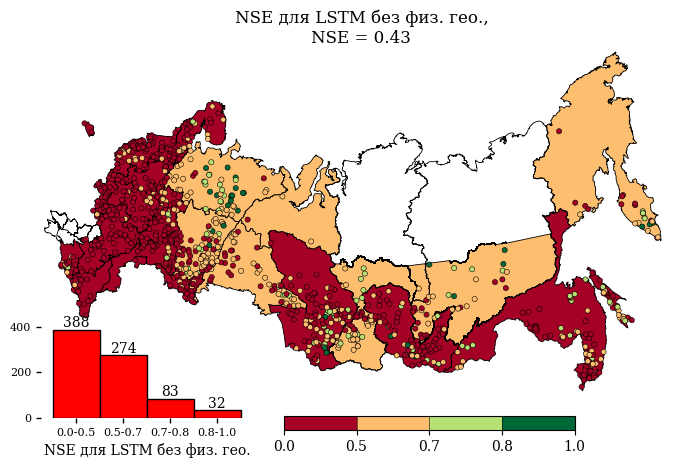

In [38]:
lstm_vanila_table, lstm_vanila_nse = read_table_gauge_str(
    table_path="./tables/LSTM_no_static_res.csv", index_filter=common_index
)

lstm_vanila_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_vanila_geom_nse.loc[:, ["NSE LSTM без физ. гео."]] = pd.concat(
    [lstm_vanila_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_vanila_geom_nse = lstm_vanila_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_vanila_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_vanila_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM без физ. гео."]] = ugms_part[["NSE LSTM без физ. гео."]].median()

basin_districts.loc[[26, 27], ["NSE LSTM без физ. гео."]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_vanila_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM без физ. гео."],
    hist_name=["NSE для LSTM без физ. гео."],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM без физ. гео.,\nNSE = {lstm_vanila_nse:.2f}"
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


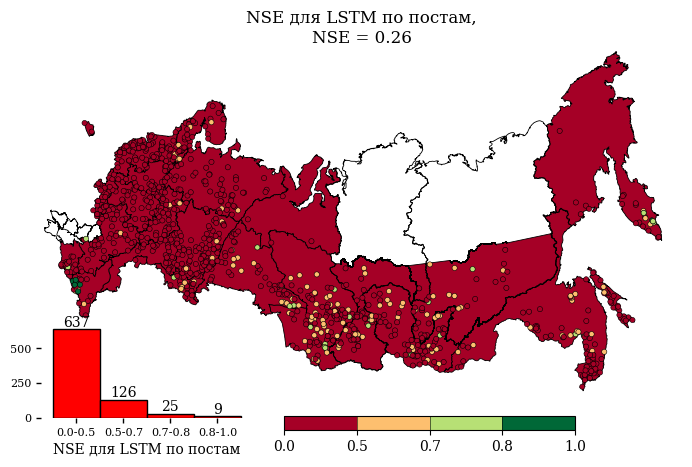

In [39]:
lstm_single_table, lstm_single_nse = read_table_gauge_str(
    table_path="./tables/Single_LSTM_table.csv", index_filter=common_index
)

lstm_single_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_single_geom_nse.loc[:, ["NSE LSTM по постам"]] = pd.concat(
    [lstm_single_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_single_geom_nse = lstm_single_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_single_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_single_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM по постам"]] = ugms_part[["NSE LSTM по постам"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM по постам"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_single_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM по постам"],
    hist_name=["NSE для LSTM по постам"],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM по постам,\nNSE = {lstm_single_nse:.2f}"
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


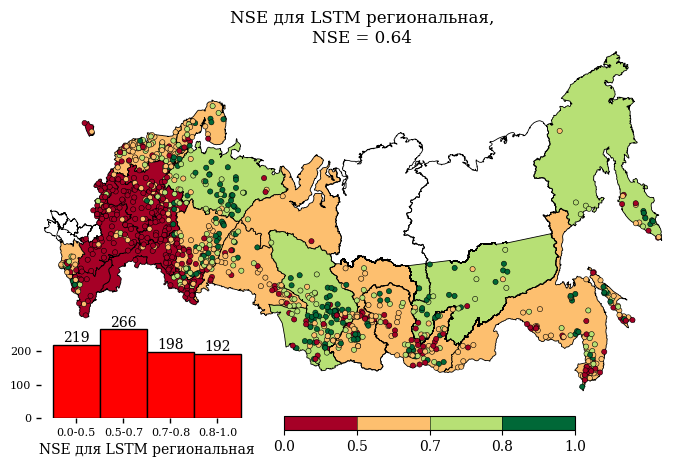

In [109]:
lstm_regional_table, lstm_regional_nse = read_table_gauge_str(
    table_path="./tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)

lstm_regional_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_regional_geom_nse.loc[:, ["NSE LSTM региональная"]] = pd.concat(
    [lstm_regional_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_regional_geom_nse = lstm_regional_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_regional_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_regional_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM региональная"]] = ugms_part[["NSE LSTM региональная"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM региональная"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_regional_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM региональная"],
    hist_name=["NSE для LSTM региональная"],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM региональная,\nNSE = {lstm_regional_nse:.2f}"
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [110]:
lstm_s = pd.concat([lstm_regional_table.median().to_frame().T, lstm_single_table.median().to_frame().T, lstm_vanila_table.median().to_frame().T])

lstm_s.index = pd.Index(["LSTM-региональная", "LSTM-по постам", "LSTM-без физ. гео."])

lstm_s.to_excel("/app/geo_data/results/lstm_s_statistics.xlsx",
                  float_format="%.2f")

### LSTM-ERA5, LSTM-MSWEP, LSTM-ERA5-Land, LSTM-GPCP

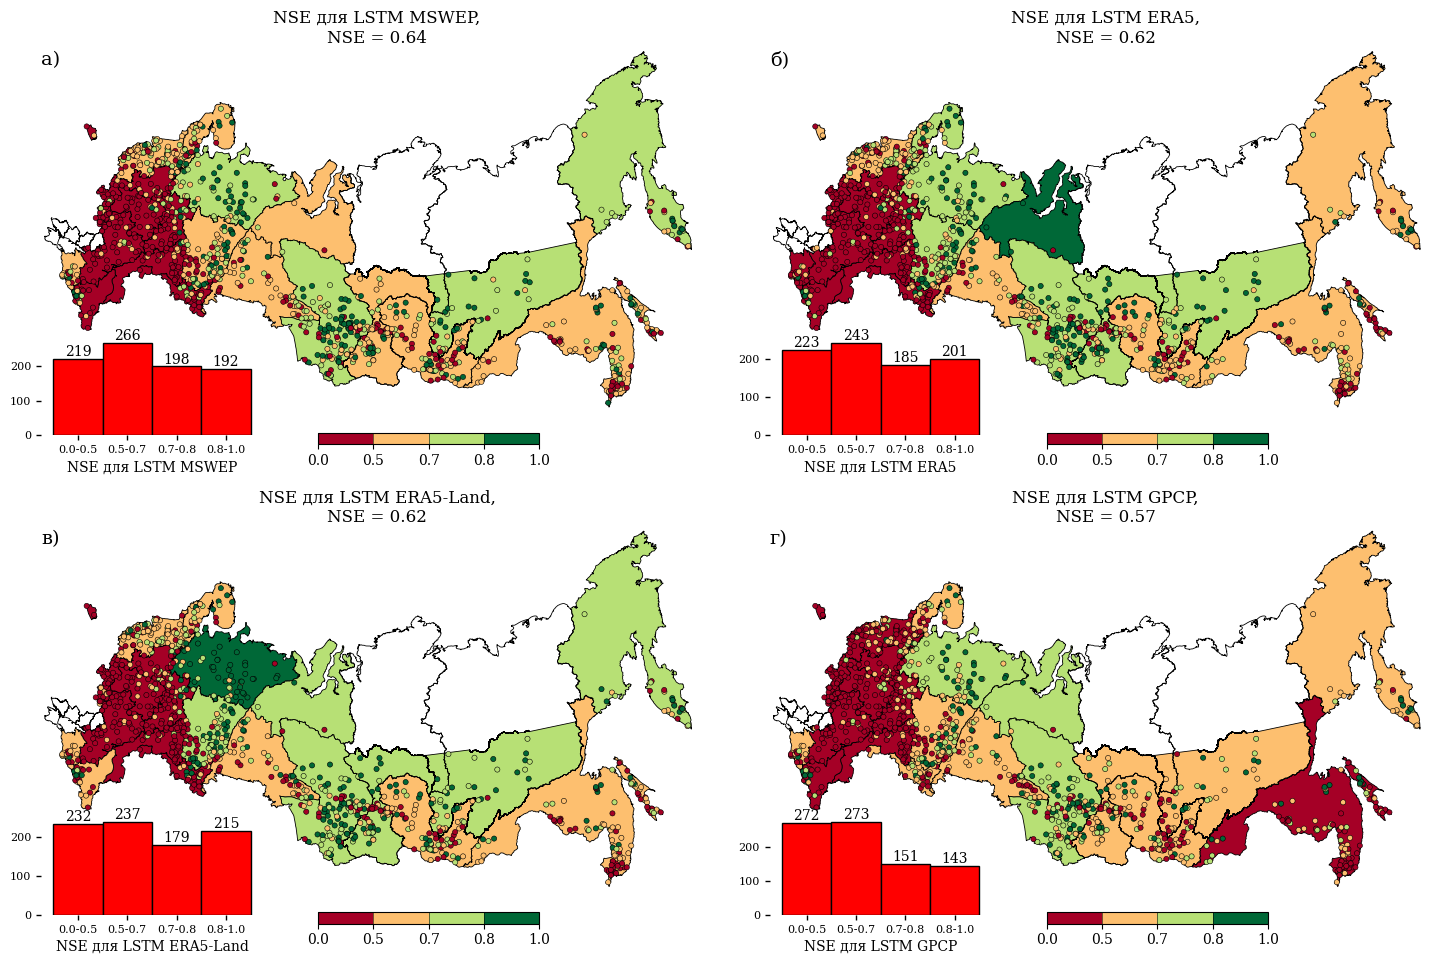

In [127]:
lstm_mswep_table, lstm_mswep_nse = read_table_gauge_str(
    table_path="./tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)
lstm_era5_table, lstm_era5_nse = read_table_gauge_str(
    table_path="./tables/cudalstm_q_mm_day_era5_res.csv", index_filter=common_index
)
lstm_era5_land_table, lstm_era5_land_nse = read_table_gauge_str(
    table_path="./tables/cudalstm_q_mm_day_era5l_res.csv", index_filter=common_index
)
lstm_gpcp_table, lstm_gpcp_nse = read_table_gauge_str(
    table_path="./tables/cudalstm_q_mm_day_gpcp_res.csv", index_filter=common_index
)

lstm_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_geom_nse.loc[:, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]] = (
    pd.concat(
        [
            lstm_mswep_table.loc[common_index, "NSE"],
            lstm_era5_table.loc[common_index, "NSE"],
            lstm_era5_land_table.loc[common_index, "NSE"],
            lstm_gpcp_table.loc[common_index, "NSE"],
        ],
        axis=1,
    ).values
)
lstm_geom_nse = lstm_geom_nse.dropna()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[
        i, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
    ] = ugms_part[["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]].median()

basin_districts.loc[
    [26, 27], ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=2,
    ncols=2,
    label_list=["а)", "б)", "в)", "г)"],
    columns_from_gdf=["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"],
    hist_name=["NSE для LSTM MSWEP", "NSE для LSTM ERA5", "NSE для LSTM ERA5-Land", "NSE для LSTM GPCP"],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM MSWEP,\nNSE = {lstm_mswep_nse:.2f}",
        f"NSE для LSTM ERA5,\nNSE = {lstm_era5_nse:.2f}",
        f"NSE для LSTM ERA5-Land,\nNSE = {lstm_era5_land_nse:.2f}",
        f"NSE для LSTM GPCP,\nNSE = {lstm_gpcp_nse:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [128]:
lstm_geom_nse['best NSE'] = lstm_geom_nse[["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]].max(axis=1)
mswep_index = lstm_geom_nse[lstm_geom_nse['best NSE'].isin(lstm_geom_nse["NSE LSTM MSWEP"])].index
era5_index = lstm_geom_nse[lstm_geom_nse['best NSE'].isin(lstm_geom_nse["NSE LSTM ERA5"])].index
era5_land_index = lstm_geom_nse[lstm_geom_nse['best NSE'].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])].index
gpcp_index = lstm_geom_nse[lstm_geom_nse['best NSE'].isin(lstm_geom_nse["NSE LSTM GPCP"])].index

for name, index in {"MSWEP": mswep_index, "ERA5": era5_index,
                    "ERA5-Land": era5_land_index, "GPCP": gpcp_index}.items():
    lstm_geom_nse.loc[index, "Лучшая модель"] = name

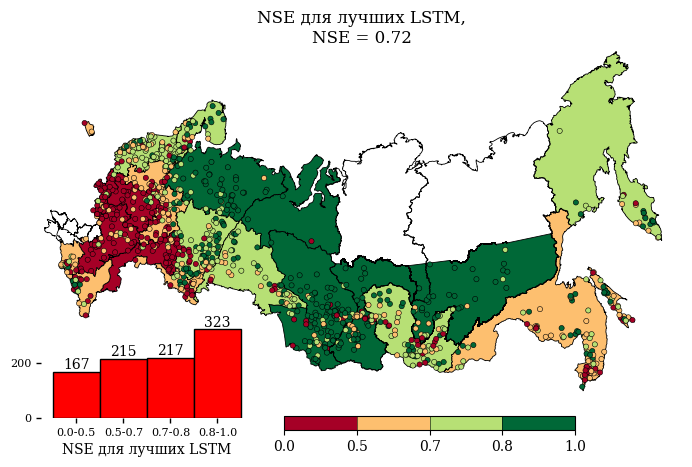

In [129]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["best NSE"]] = ugms_part[["best NSE"]].median()

basin_districts.loc[[26, 27], ["best NSE"]] = np.NaN

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["best NSE"],
    hist_name=["NSE для лучших LSTM"],
    with_histogram=True,
    title_text=[
        f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['best NSE'].median():.2f}"
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


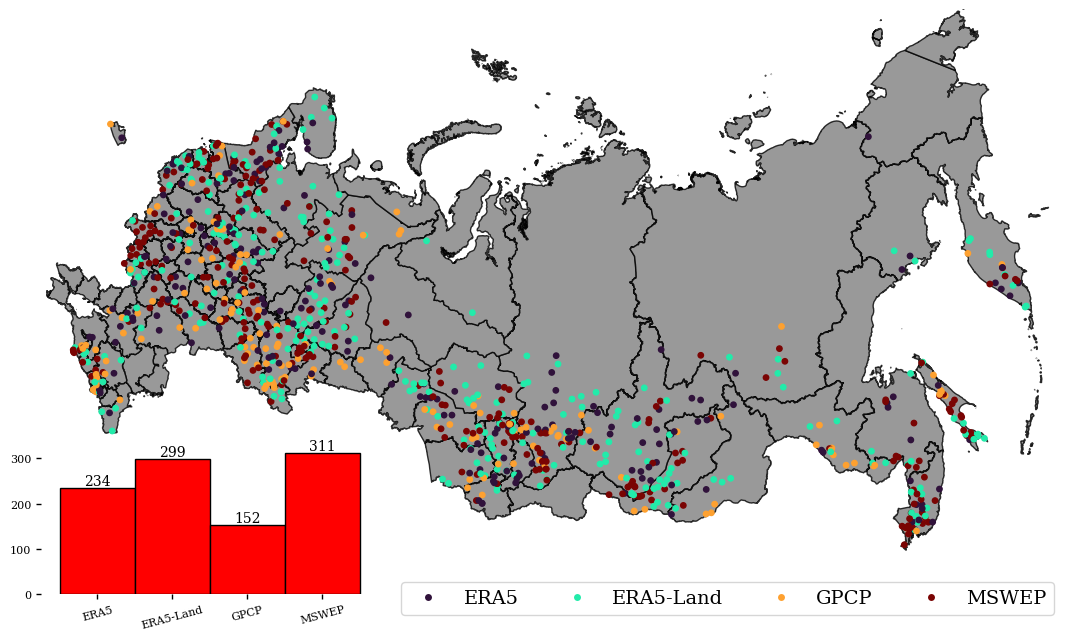

In [130]:
gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=True)

In [144]:
best_lstm_table = pd.concat([lstm_mswep_table.loc[mswep_index, :].median().to_frame().T, lstm_era5_land_table.loc[era5_land_index, :].median().to_frame().T,
                             lstm_era5_table.loc[era5_index, :].median().to_frame().T, lstm_gpcp_table.loc[gpcp_index, :].median().to_frame().T]).median().to_frame().T

lstm_s_meteo = pd.concat([lstm_mswep_table.median().to_frame().T, lstm_era5_table.median().to_frame().T,
                          lstm_era5_land_table.median().to_frame().T, lstm_gpcp_table.median().to_frame().T, best_lstm_table])

lstm_s_meteo.index = pd.Index(["LSTM MSWEP", "LSTM ERA5", "LSTM ERA5-Land", "LSTM GPCP", "Лучшие LSTM"])

lstm_s_meteo.to_excel("/app/geo_data/results/lstm_s_meteo_statistics.xlsx",
                      float_format="%.2f")

In [ ]:

best_lstm_table.index = pd.Index(["LSTM MSWEP", "LSTM ERA5", "LSTM ERA5-Land", "LSTM GPCP"])

best_lstm_table.to_excel("/app/geo_data/results/lstm_s_meteo_statistics.xlsx",
                      float_format="%.2f")

### HBV, GR4J, LSTM-regional, LSTM-single, LSTM-vanila, Random Forest

### Comparison tables